#### Download data
Downloaded all netCDF files from NOAA repository with:  
`parallel < download.txt`
Where parallel is GNU parallel and download.txt contains a wget command on each line for 310 files, e.g.:  
`wget https://www1.ncdc.noaa.gov/pub/data/paleo/treering/reconstructions/northamerica/usa/bocinsky2016/103W31N_GDD.nc4`

#### Build virtual raster

In [1]:
!gdalbuildvrt ncGDD.vrt *GDD.nc4

0Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time

#### Don't do this:

In [2]:
!gdalinfo ncGDD.vrt

Terminated


This was a bad idea; gdalinfo checking every netCDF file in the VRT started using tons of memory:  
``` USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND
cgtrn05   20   0 20.991g 0.020t   1512 D  22.7 65.8   0:57.82 gdalinfo ```

#### Try to make a single band output: 

Works for a single tile:

In [3]:
!gdal_translate -b 1000 103W31N_GDD.nc4 bands/103W31N_GDD.nc4-1000.tif -co COMPRESS=DEFLATE -co BIGTIFF=YES -ot Int16 -co TILED=YES

Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Input file size is 120, 120
0...10...20...30...40...50...60...70...80...90...100 - done.


Memory is out of control when trying to use the VRT:

In [4]:
!gdal_translate -b 1000 ncGDD.vrt bands/GDD_may_sept_demosaic-1000.tif -co COMPRESS=DEFLATE -co BIGTIFF=YES -ot Int16 -co TILED=YES

^C


#### Switch to longitude columns for combining NOAA data
I believe Adam's workflow was similiar

In [8]:
!time gdalbuildvrt 103W_GDD.vrt *103*GDD.nc4

0...Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
10..Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.20..Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.30.Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
..40Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
...50Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
...Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
60..Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.70..Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.80.Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
..90Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
...100 - done.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
3.57user 0.28system 0:04.18elapsed 92%CPU (0avgtext+0avgdata 128140maxresident)k
0inputs+19944outputs (0major+25403minor)pa

#### Make a single band TIF from VRT column

In [9]:
!gdal_translate -b 1000 103W_GDD.vrt bands/103W_GDD-1000.tif -co COMPRESS=DEFLATE -co BIGTIFF=YES -ot Int16 -co TILED=YES

Input file size is 120, 1440
0Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
...10...20...30...40...50...60...70...80...Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
90...100 - done.


In [10]:
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
%matplotlib inline

input_file = os.path.join(os.path.abspath('.'), 'bands', '103W_GDD-1000.tif')
if not os.path.exists(input_file):
    print('File not found')
else:
    print('Input file:', input_file)

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Input file: /mnt/skope/noaaData/bands/103W_GDD-1000.tif


BoundingBox(left=-102.995833334, bottom=30.99583333400007, right=-101.99583333399998, top=42.995833334)


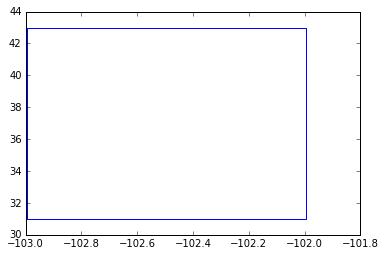

In [11]:
with rasterio.open(input_file) as src:
    print(src.bounds)
    left, bottom, right, top = src.bounds
x = [left, right, right, left, left]
y = [bottom, bottom, top, top, bottom]
plt.plot(x, y)

In [12]:
?np.dstack()

In [15]:
with rasterio.open(input_file) as src:
    data = src.read(1)
data.shape

(1440, 120)

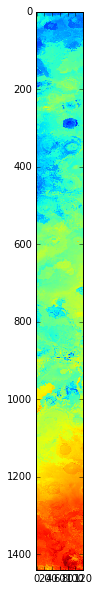

In [17]:
plt.figure(figsize=(2, 10))
plt.imshow(data)

#### Columns work, finish creating VRTs for rest of the columns

In [19]:
!for var in 104 105 106 107 108 109 110 111 112 113 114 115; do gdalbuildvrt "$var"W_GDD.vrt *"$var"*GDD.nc4; done

0...Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
10..Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.20..Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.30.Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
..40Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
...50Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
...Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
60..Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.70..Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
.80.Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
..90Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
...100 - done.
Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
0...Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
10..Warning 1: dimension #0 (Year) is not a Time or

In [20]:
!gdalinfo 104W_GDD.vrt | head -n 40

Warning 1: dimension #0 (Year) is not a Time or Vertical dimension.
Driver: VRT/Virtual Raster
Files: 104W_GDD.vrt
       /mnt/skope/noaaData/104W31N_GDD.nc4
       /mnt/skope/noaaData/104W32N_GDD.nc4
       /mnt/skope/noaaData/104W33N_GDD.nc4
       /mnt/skope/noaaData/104W34N_GDD.nc4
       /mnt/skope/noaaData/104W35N_GDD.nc4
       /mnt/skope/noaaData/104W36N_GDD.nc4
       /mnt/skope/noaaData/104W37N_GDD.nc4
       /mnt/skope/noaaData/104W38N_GDD.nc4
       /mnt/skope/noaaData/104W39N_GDD.nc4
       /mnt/skope/noaaData/104W40N_GDD.nc4
       /mnt/skope/noaaData/104W41N_GDD.nc4
       /mnt/skope/noaaData/104W42N_GDD.nc4
Size is 120, 1440
Coordinate System is `'
Origin = (-103.995833333999997,42.995833333999997)
Pixel Size = (0.008333333333333,-0.008333333333333)
Corner Coordinates:
Upper Left  (-103.9958333,  42.9958333) 
Lower Left  (-103.9958333,  30.9958333) 
Upper Right (-102.9958333,  42.9958333) 
Lower Right (-102.9958333,  30.9958333) 
Center      (-103.4958333,  36.9958333) 